In [985]:
import sys
import json
from os import listdir
from itertools import product
import importlib
import matplotlib.pyplot as plt
import numpy as np

import input_output
importlib.reload(input_output)
import inheritance_states
importlib.reload(inheritance_states)
import transition_matrices
importlib.reload(transition_matrices)
import genotypes
importlib.reload(genotypes)
import losses
importlib.reload(losses)
import viterbi
importlib.reload(viterbi)

<module 'viterbi' from '/Users/kelley/Projects/PhasingFamilies/phase/viterbi.py'>

In [984]:
# Read in command line arguments
chrom = '5'

data_dir = '../../DATA/ihart/genotypes'
param_file = '../params/ihart_multiloss_params.json'
num_loss_regions = 2
assembly = '37'
ped_file = '../../DATA/ihart/ihart.ped'
###detect_deletions = False
###ped_file = '../../DATA/ihart/ihart.ped'

#data_dir = '../../DATA/spark/genotypes'
#ped_file = '../../DATA/spark/spark.ped.quads.ped'
#param_file = '../params/spark_quads_multiloss_params.json'
#num_loss_regions = 1
#assembly = '38'

#data_dir = '../../DATA/ancestry/genotypes'
#ped_file = '../../DATA/ancestry/ancestry.ped'
#param_file = '../params/ancestry_multiloss_params.json'
#num_loss_regions = 1
#assembly = '37'

detect_deletions = False
detect_consanguinity = False

# set up filenames
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
coord_file = '%s/chr.%s.gen.coordinates.npy' % (data_dir,  chrom)
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])

with open(param_file, 'r') as f: 
    params = json.load(f)

In [901]:
#params['-log10(P[maternal_crossover])'] = 100
#params['-log10(P[paternal_crossover])'] = 100

In [902]:
# pull families of interest
families = input_output.pull_families(ped_file)

families pulled 1002


In [905]:
# make sure at least one individual has genetic data (chromosome 1 chosen arbitrarily)
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
with open(sample_file, 'r') as f:
    sample_ids = set([line.strip() for line in f])
families = [x for x in families if len(set(x.individuals) & sample_ids)>0]

In [906]:
num_unrelated_individuals = sum([f.num_ancestors() for f in families])
print('unrelated individuals in dataset', num_unrelated_individuals)


unrelated individuals in dataset 2110


In [940]:
af_boundaries = np.arange(-np.log10(0.25), np.log10(2*num_unrelated_individuals/3), np.log10(2)).tolist() # use rule of 3; we can't differentiate allele frequencies any smaller than 3/(2*num unrelated individuals).
af_boundaries.extend([-np.log10(1-(10.0**-x)) for x in af_boundaries[1:]])
af_boundaries = np.array(sorted(af_boundaries, reverse=True))
print(af_boundaries)


[3.01029996e+00 2.70926996e+00 2.40823997e+00 2.10720997e+00
 1.80617997e+00 1.50514998e+00 1.20411998e+00 9.03089987e-01
 6.02059991e-01 5.79919470e-02 2.80287236e-02 1.37882845e-02
 6.83942453e-03 3.40624869e-03 1.69978488e-03 8.49060841e-04
 4.24322928e-04]


In [930]:
# if we're detecting consanguinity, restrict to nuclear families
if detect_consanguinity:
    families = [x for x in families if x.num_ancestors()==2 and len(x.ordered_couples)==1]
    
    # to detect consanguinity, model a shared ancestor
    for family in families:
        family.add_child(family.mat_ancestors[0], 'mat_shared_ancestor', 'pat_shared_ancestor')
        family.add_child(family.pat_ancestors[0], 'mat_shared_ancestor', 'pat_shared_ancestor')
    
print(len(families))

1001


In [969]:
import random


family = random.choice(families)
#family = [f for f in families if f.id=='SF0006106.SP0006106.SP0006171'][0]
#family = [f for f in families if f.id=='AU0358'][0]
print('family', family.id, family.individuals)
print(family.parents_to_children.items())

family AU0803 ['AU0803202', 'AU0803201', 'AU0803301', 'AU0803302']
dict_items([(('AU0803202', 'AU0803201'), ['AU0803301', 'AU0803302'])])


In [1014]:
importlib.reload(inheritance_states)
importlib.reload(transition_matrices)

# create inheritance states
if chrom == 'X':
    states = inheritance_states.InheritanceStates(family, detect_deletions, True, num_loss_regions)
else:
    states = inheritance_states.InheritanceStates(family, detect_deletions, detect_deletions, num_loss_regions)

# create transition matrix
transitions = transition_matrices.TransitionMatrix(states, params)
                

fixed [('AU0803301', 'mat'), ('AU0803301', 'pat')]
inheritance states (8, 9)
transitions (8, 4)


In [1004]:
importlib.reload(losses)

# create loss function
loss = losses.LazyLoss(states, family, params, num_loss_regions, af_boundaries)


no data []
AU0803202
	0/0	0/1	1/1	./.
0/0	0.0003-0.0051	3.6932-2.4070	5.2070-5.0961	3.3659-2.1136
0/1	2.2455-1.2430	0.0036-0.0459	2.8723-1.8223	2.9155-1.5510
1/1	4.3699-3.9090	3.5939-1.9151	0.0003-0.0075	3.3686-2.3187
-/0	0.0003-0.0051	3.6932-2.4070	5.2070-5.0961	3.3659-2.1136
-/1	4.3699-3.9090	3.5939-1.9151	0.0003-0.0075	3.3686-2.3187
-/-	3.5939-1.9151	4.7885-4.5025	3.6932-2.4070	0.0002-0.0071
AU0803201
	0/0	0/1	1/1	./.
0/0	0.0004-0.0072	3.6932-2.4070	5.3305-4.9474	3.1980-1.9046
0/1	2.2926-1.1930	0.0032-0.0569	2.9771-1.7124	2.9644-1.4064
1/1	5.4057-3.8954	3.5939-1.9151	0.0005-0.0086	3.0752-2.1318
-/0	0.0004-0.0072	3.6932-2.4070	5.3305-4.9474	3.1980-1.9046
-/1	5.4057-3.8954	3.5939-1.9151	0.0005-0.0086	3.0752-2.1318
-/-	3.5939-1.9151	5.3681-4.4214	3.6932-2.4070	0.0002-0.0071
AU0803301
	0/0	0/1	1/1	./.
0/0	0.0003-0.0047	3.6454-2.3929	5.7456-4.1542	3.4422-2.1843
0/1	2.9112-1.8858	0.0008-0.0120	3.8781-2.3291	3.4244-2.0178
1/1	4.9496-3.0785	3.5527-1.9727	0.0003-0.0080	3.4192-2.1659
-/0	0.00

In [1005]:
af_index = random.choice(np.arange(1, len(af_boundaries)))
total_prob = np.zeros((states.num_states,))
for gen in np.array(list(product(*([[0, 1, 2, -1]]*len(family)) + [[af_index]]))):
    if np.all(gen[:-1]==0) or np.any(gen[:-1]>0):
        total_prob += np.power(10, -loss(gen))
        
assert np.all(np.isclose(total_prob, 1))

In [1006]:
import input_output
importlib.reload(input_output)

# pull genotype data for this family
family_genotypes, family_snp_positions, mult_factor = input_output.pull_gen_data_for_individuals(data_dir, af_boundaries, assembly, chrom, family.individuals)
print('Data pulled')



(4, 4522196) (4522196,)
genotypes pulled (5, 2628791) [[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 9 0 ... 0 8 0]]
Data pulled


In [1007]:
loss.set_cache(family_genotypes)


cached losses (8, 515) already_calculated 0


In [1008]:
loss(np.zeros((len(family)+1,), dtype=int))

array([0.00205118, 0.00850509, 0.0020538 , 0.00854662, 0.0020541 ,
       0.00853935, 0.00205671, 0.00858088])

In [1019]:
importlib.reload(viterbi)

# forward sweep
v_cost = viterbi.viterbi_forward_sweep(family_genotypes, family_snp_positions, mult_factor, states, transitions, loss)




Forward sweep complete 137.29558897018433 sec


In [1010]:
importlib.reload(viterbi)

# backward sweep
final_states = viterbi.viterbi_backward_sweep(v_cost, states, transitions)


Num solutions (1,) 440474.6066895136 (array([1, 1, 1, 1, 0, 0, 1, 0, 0], dtype=int8),)
(1,)
Num positions in fork 19284
Backward sweep complete 301.3729159832001 sec


In [1020]:
importlib.reload(viterbi)

# backward sweep
final_states = viterbi.viterbi_backward_sweep(v_cost, states, transitions)


Num solutions (1,) 440474.6066895136 (array([1, 1, 1, 1, 0, 0, 1, 0, 0], dtype=int8),)
Num forks 19284
Backward sweep complete 280.73376393318176 sec


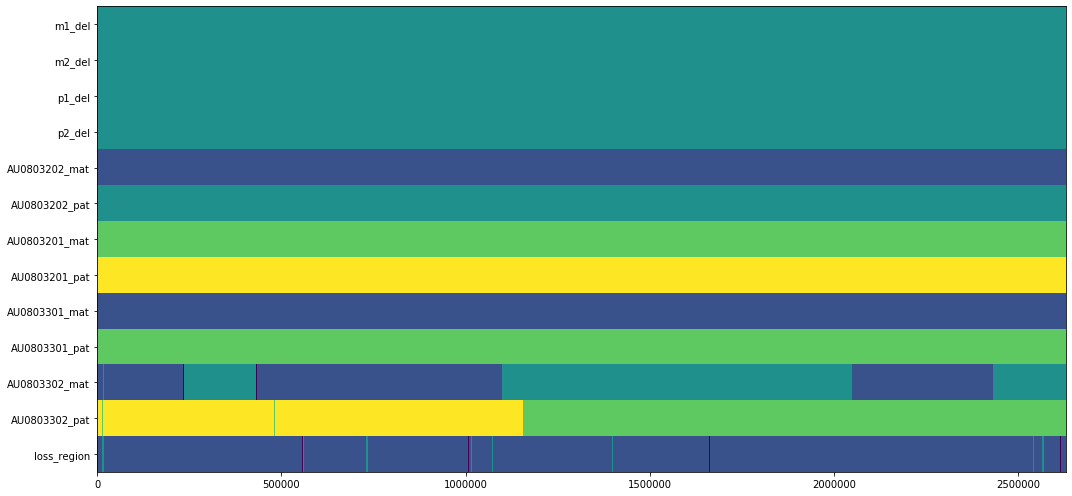

In [1011]:
final_states_greyed = final_states.copy()
final_states_greyed[:, final_states[-1, :]!=0] = -1

plt.figure(figsize=(15, 7))
plt.imshow(final_states, aspect='auto', vmin=-1)
plt.yticks(np.arange(final_states.shape[0]), 
           ['m%d_del' % i for i in range(1, 2*len(family.mat_ancestors)+1)] + ['p%d_del' % i for i in range(1, 2*len(family.pat_ancestors)+1)] + \
           sum([['%s_mat' % x,'%s_pat' % x] for x in family.individuals], []) + ['loss_region'])

#plt.subplot(2, 1, 2, sharex=ax)
#plt.fill_between(np.arange(family_snp_positions.shape[0]), 0, (family_snp_positions[:, 0]>=0) & (family_snp_positions[:, 1]<=20500000), alpha=0.5)
#plt.fill_between(np.arange(family_snp_positions.shape[0]), 0, (family_snp_positions[:, 0]>=9600000) & (family_snp_positions[:, 1]<=16300000))
#plt.fill_between(np.arange(family_snp_positions.shape[0]), 0, (family_snp_positions[:, 1]<=9600000) | (family_snp_positions[:, 0]>=48200000))

#plt.xticks(xticks, xlabels, rotation=90)

#plt.subplot(3, 1, 3)
#plt.plot(np.log2(family_snp_positions[:, 1]-family_snp_positions[:, 0]), marker='.', linestyle='')
#plt.plot(c[1:]-c[:-1], marker='.', linestyle='')
#plt.plot(num_non_mend, marker='.', linestyle='')
#plt.plot(np.convolve(num_non_mend, np.ones((100,)), mode='same'))
#plt.plot(np.convolve(num_missing, np.ones((100,)), mode='same'))
#plt.scatter(family_snp_positions[:, 0], final_states[-1, :], marker='.')
#plt.xticks(family_snp_positions[xticks, 0], xlabels, rotation=90)
#for i in np.where(family_snp_positions[:, 1]-family_snp_positions[:, 0] > 10000)[0]:
#    plt.plot([family_snp_positions[i, 0], family_snp_positions[i, 1]], [final_states[-1, i], final_states[-1, i]], color='grey')
#    #print(family_snp_positions[i, :])
plt.tight_layout()
plt.show()

In [981]:
np.sum((final_states[-1, :]==0)*mult_factor)/np.sum(mult_factor)


0.0

In [56]:
print(np.sum((final_states[10, :]==0)*mult_factor)/np.sum(mult_factor))
print(np.sum((final_states[11, :]==2)*mult_factor)/np.sum(mult_factor))


0.08166433284944095
0.3331245744530517


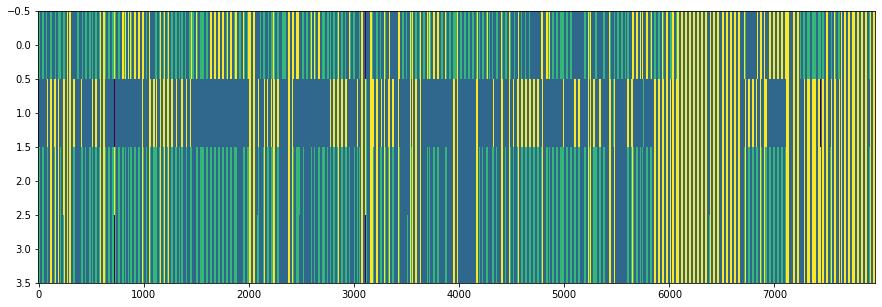

In [598]:
plt.figure(figsize=(15, 5))
indices = final_states[3, :]==0
plt.imshow(family_genotypes[2:-1, indices], aspect='auto', vmin=-1, vmax=2)
plt.show()